In [1]:
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import urllib.request as request

# =========================
# 1. FUNCTION WORD LIST
# =========================
function_words = [
    'the','of','and','to','in','for','with','on','at','by',
    'she','he','it','they','you','we','his','her','their',
    'is','was','be','been','are','not','as','from','that',
    'this','but','or','if','while','who','whom','which'
]

# =========================
# 2. PREPROCESS
# =========================
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    return tokens

def chunk_tokens(tokens, chunk_size=100):
    chunks = []
    for i in range(0, len(tokens), chunk_size):
        chunk = tokens[i:i+chunk_size]
        if len(chunk) >= 30: # Changed from 50 to 30 to allow shorter texts to be processed
            chunks.append(" ".join(chunk))
    return chunks

# =========================
# 3. TRAINING TEXTS
# =========================
url1 = "https://www.gutenberg.org/cache/epub/158/pg158.txt"
url2 = "https://www.gutenberg.org/files/768/768-h/768-h.htm"

response= request.urlopen(url1)
austen_text = response.read().decode('utf8')

response= request.urlopen(url2)
bronte_text  = response.read().decode('utf8')
# =========================
# 4. PREPARE DATA
# =========================
austen_tokens = [t for t in preprocess_text(austen_text) if t in function_words]
bronte_tokens = [t for t in preprocess_text(bronte_text) if t in function_words]

austen_docs = chunk_tokens(austen_tokens)
bronte_docs = chunk_tokens(bronte_tokens)

docs = austen_docs + bronte_docs
labels = ["Austen"] * len(austen_docs) + ["bronte"] * len(bronte_docs)

In [2]:
# =========================
# 5. VSM (TF-IDF)
# =========================
vectorizer = TfidfVectorizer(vocabulary=function_words)
X = vectorizer.fit_transform(docs)
y = np.array(labels)

In [3]:
# =========================
# 6. TRAIN MODEL
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = LinearSVC()
model.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))

Accuracy: 0.8686868686868687


In [4]:
# =========================
# UNKNOWN TEXT INPUT
# =========================
unknown_text = """Occupied in observing Mr. Bingley's attentions to her sister,
Elizabeth was far from suspecting that she was herself becoming an object of some
interest in the eyes of his friend. Mr. Darcy had at first scarcely allowed her to be pretty;
he had looked at her without admiration at the ball; and when they next met, he looked at her
only to criticise. But no sooner had he made it clear to himself and his friends that she had hardly
 a good feature in her face, than he began to find it was rendered uncommonly intelligent by the
 beautiful expression of her dark eyes. To this discovery succeeded some others equally mortifying.
  Though he had detected with a critical eye more than one failure of perfect symmetry in her form,
   he was forced to acknowledge her figure to be light and pleasing; and in spite of his asserting
   that her manners were not those of the fashionable world, he was caught by their easy playfulness.
    Of this she was perfectly unaware;—to her he was only the man who made himself agreeable no where, and who had not thought her handsome enough to dance with.
"""


In [5]:
# =========================
# 7. UNKNOWN AUTHOR TEST (PROPER)
# =========================
MARGIN_THRESHOLD = 0.7

unknown_tokens = [t for t in preprocess_text(unknown_text) if t in function_words]
# Modified: Treat unknown_tokens as a single document if it's not empty, bypassing chunking for short texts.
if unknown_tokens:
    unknown_docs = [" ".join(unknown_tokens)]
else:
    # Handle case where unknown_tokens might be completely empty, though unlikely with current text
    unknown_docs = []

X_unknown = vectorizer.transform(unknown_docs)

# Only proceed with prediction if X_unknown has samples
if X_unknown.shape[0] > 0:
    preds = model.predict(X_unknown)
    margins = model.decision_function(X_unknown)
    abs_margins = np.abs(margins)

    unique, counts = np.unique(preds, return_counts=True)
    votes = dict(zip(unique, counts))

    winner = max(votes, key=votes.get)
    mean_margin = abs_margins.mean()

    print("\n--- UNKNOWN AUTHOR RESULT ---")
    print("Chunk votes:", votes)
    print("Mean margin confidence:", round(mean_margin, 3))

    if mean_margin < MARGIN_THRESHOLD:
        print("Final decision: UNKNOWN AUTHOR")
    else:
        print(f"Final decision: {winner}")
else:
    print("\n--- UNKNOWN AUTHOR RESULT ---")
    print("Not enough relevant text to determine the author.")


--- UNKNOWN AUTHOR RESULT ---
Chunk votes: {np.str_('Austen'): np.int64(1)}
Mean margin confidence: 0.999
Final decision: Austen


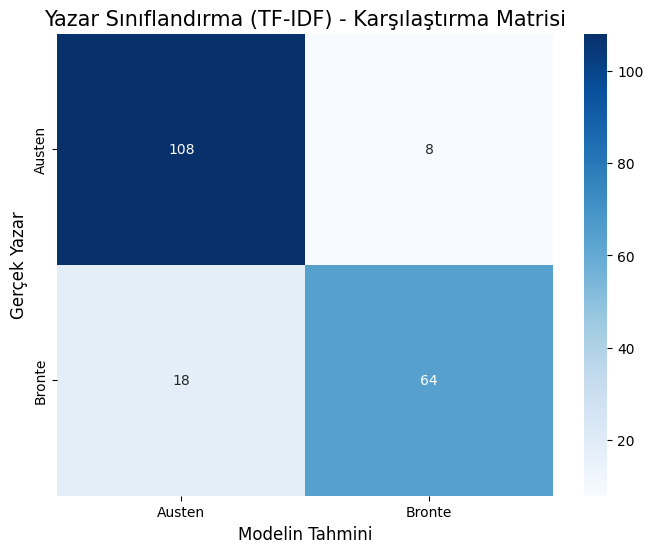

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Notebook'undaki değişkenleri kullanarak tahminleri alıyoruz
# 'true_labels' yerine 'y_test', tahminler için de 'model.predict' kullanıyoruz
preds = model.predict(X_test)
true_labels = y_test

# 2. Confusion Matrix hesapla
# DİKKAT: Notebook içinde etiket 'bronte' (küçük harf) olarak geçtiği için 
# labels kısmına tam olarak onu yazıyoruz ki sıralama karışmasın.
cm = confusion_matrix(true_labels, preds, labels=['Austen', 'bronte'])

# 3. Çizim
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Austen', 'Bronte'], # Grafikte şık durması için Büyük Harf yapıyoruz
            yticklabels=['Austen', 'Bronte'])

plt.xlabel('Modelin Tahmini', fontsize=12)
plt.ylabel('Gerçek Yazar', fontsize=12)
plt.title('Yazar Sınıflandırma (TF-IDF) - Karşılaştırma Matrisi', fontsize=15)
plt.show()

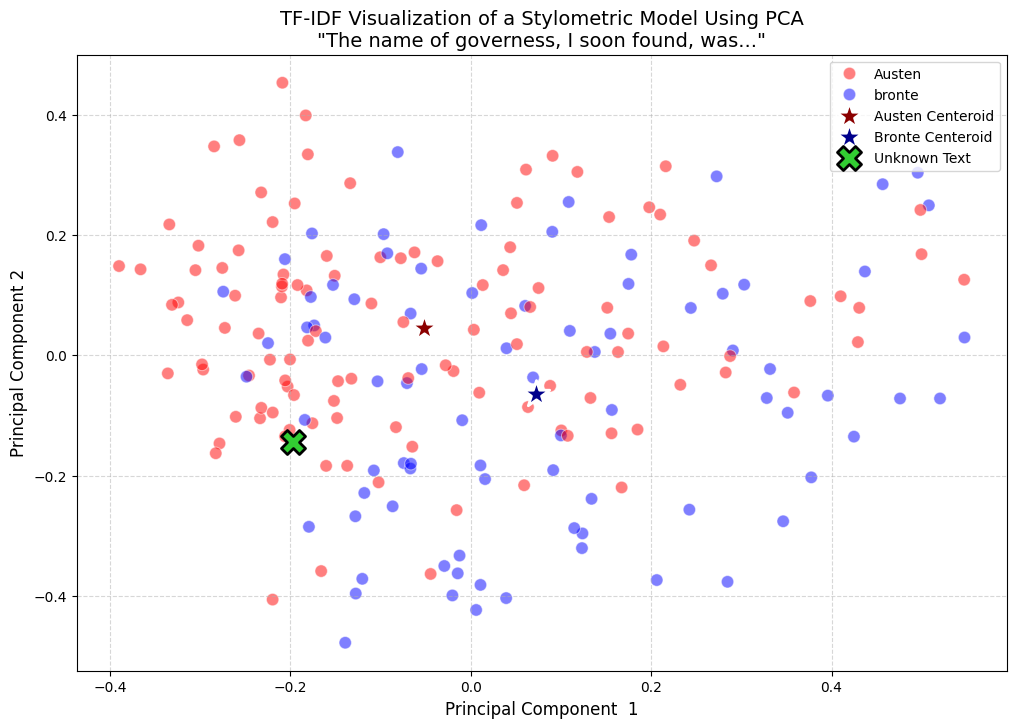

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ==========================================
# 1. VERİLERİ HAZIRLAMA
# ==========================================
# TF-IDF modelinde vektörler zaten X_test değişkeninde duruyor.
# Ancak Sparse Matrix (sıkıştırılmış) olduğu için önce normal array'e çeviriyoruz.
X_dense = X_test.toarray()
y_labels = y_test

# ==========================================
# 2. "BİLİNMEYEN" METNİN VEKTÖRÜNÜ ÇIKARMA
# ==========================================
# Test etmek istediğin cümle (Bronte'ye ait bir cümle)
unknown_text = "The name of governess, I soon found, was a mere mockery as applied to me."

# Cümleyi aynı kurallarla temizle (Notebook'undaki fonksiyonu kullanıyoruz)
unknown_tokens = [t for t in preprocess_text(unknown_text) if t in function_words]
unknown_doc = [" ".join(unknown_tokens)]

# Eğitilmiş vectorizer ile dönüştür
unknown_vector = vectorizer.transform(unknown_doc).toarray()

# ==========================================
# 3. PCA UYGULAMA VE GÖRSELLEŞTİRME
# ==========================================
# PCA Kur
pca = PCA(n_components=2)

# Vektörleri 2 boyuta indirge
X_pca = pca.fit_transform(X_dense)

# Bilinmeyen metni de aynı uzaya düşür
u_pca = pca.transform(unknown_vector)[0]

# DataFrame Oluştur
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Yazar'] = y_labels

# Merkezleri (Centroids) Hesapla
# Not: Senin veri setinde etiket 'bronte' (küçük harf) olarak geçiyordu
centroid_austen = df_pca[df_pca['Yazar'] == 'Austen'][['PC1', 'PC2']].mean()
centroid_bronte = df_pca[df_pca['Yazar'] == 'bronte'][['PC1', 'PC2']].mean()

# --- ÇİZİM ---
plt.figure(figsize=(12, 8))

# 1. Tüm noktaları çiz
# 'bronte' etiketini grafikte 'Anne Bronte' gibi göstermek için palette kullanıyoruz
sns.scatterplot(x='PC1', y='PC2', hue='Yazar', data=df_pca, 
                palette={'Austen': 'red', 'bronte': 'blue'}, 
                alpha=0.5, s=80)

# 2. Merkezleri (Centroids) Yıldız Olarak Ekle
plt.scatter(centroid_austen['PC1'], centroid_austen['PC2'], 
            marker='*', s=400, color='darkred', label='Austen Centeroid', edgecolors='white', linewidth=2)
plt.scatter(centroid_bronte['PC1'], centroid_bronte['PC2'], 
            marker='*', s=400, color='darkblue', label='Bronte Centeroid', edgecolors='white', linewidth=2)

# 3. Bilinmeyen Metni Ekle (Yeşil X)
plt.scatter(u_pca[0], u_pca[1], 
            marker='X', s=300, color='limegreen', label='Unknown Text', edgecolors='black', linewidth=2, zorder=10)

plt.title(f'TF-IDF Visualization of a Stylometric Model Using PCA\n"{unknown_text[:40]}..."', fontsize=14)
plt.xlabel('Principal Component  1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('tfidf_pca.png', dpi=300, bbox_inches='tight')
plt.show()

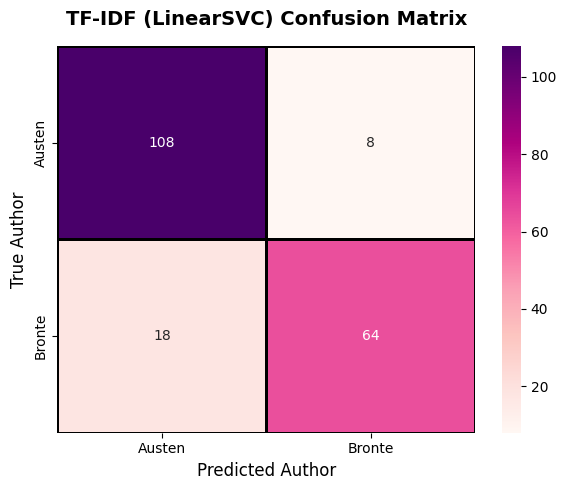

Grafik 'tfidf_confusion.png' olarak kaydedildi!


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Tahminleri Oluştur (Senin kodundaki değişken isimlerine göre)
y_pred = model.predict(X_test)

# 2. Confusion Matrix Hesapla
# DİKKAT: Kodunda etiket "bronte" (küçük harf) olarak geçtiği için buraya aynısını yazıyoruz.
# Böylece sıralama doğru oluyor.
cm_tfidf = confusion_matrix(y_test, y_pred, labels=['Austen', 'bronte'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_tfidf, 
            annot=True, 
            fmt='d', 
            cmap='RdPu',       # İstediğin Mor Tema
            xticklabels=['Austen', 'Bronte'], # Grafikte şık görünmesi için baş harfi büyüttük
            yticklabels=['Austen', 'Bronte'],
            linewidths=1, 
            linecolor='black')

plt.title("TF-IDF (LinearSVC) Confusion Matrix", fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Author', fontsize=12)
plt.xlabel('Predicted Author', fontsize=12)
plt.tight_layout()

# Kaydet
plt.savefig('tfidf_confusion.png', dpi=300)
plt.show()

print("Grafik 'tfidf_confusion.png' olarak kaydedildi!")

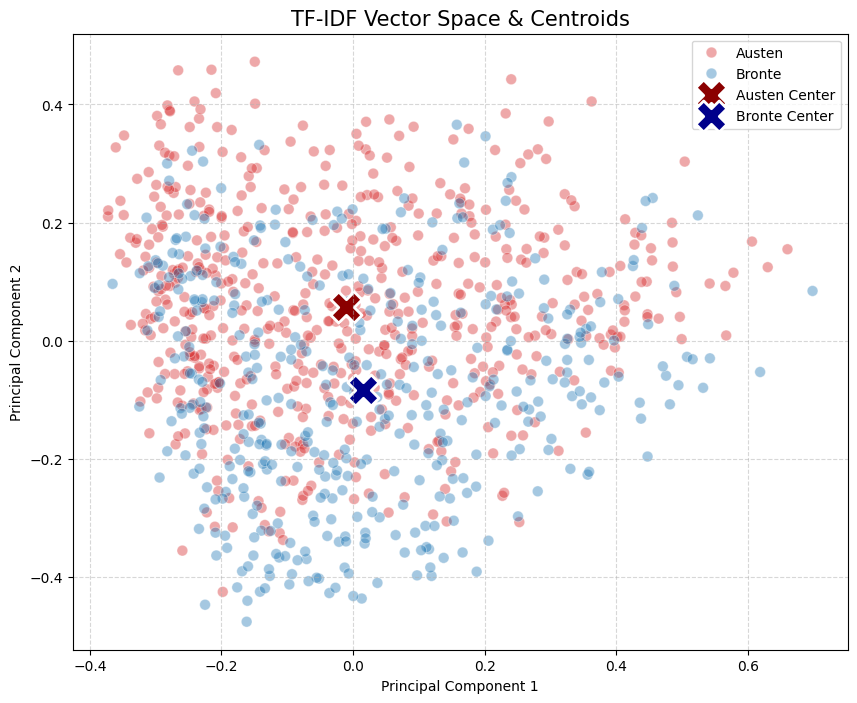

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 1. Veriyi Hazırla (Tüm Veri Seti)
X_dense = X.toarray() 
# Etiketlerde 'bronte' küçük harfli olduğu için görselde düzeltiyoruz
y_fixed = ['Austen' if label == 'Austen' else 'Bronte' for label in y]

# 2. PCA Uygula
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

# 3. DataFrame Oluştur
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Author'] = y_fixed

# 4. Merkezleri (Centroids) Hesapla
centroid_austen = df_pca[df_pca['Author'] == 'Austen'][['PC1', 'PC2']].mean()
centroid_bronte = df_pca[df_pca['Author'] == 'Bronte'][['PC1', 'PC2']].mean()

# 5. ÇİZİM (Kırmızı-Mavi Konsept)
plt.figure(figsize=(10, 8))

# Noktalar (Hafif saydam)
sns.scatterplot(x='PC1', y='PC2', hue='Author', data=df_pca, 
                palette={'Austen': '#d62728', 'Bronte': '#1f77b4'}, # Kırmızı - Mavi
                alpha=0.4, s=60)

# Merkezler (Büyük Yıldızlar)
plt.scatter(centroid_austen['PC1'], centroid_austen['PC2'], 
            color='darkred', s=500, marker='X', 
            label='Austen Center', edgecolors='white', linewidth=2)
plt.scatter(centroid_bronte['PC1'], centroid_bronte['PC2'], 
            color='darkblue', s=500, marker='X', 
            label='Bronte Center', edgecolors='white', linewidth=2)

plt.title('TF-IDF Vector Space & Centroids', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig('tfidf_pca_centroids.png', dpi=300)
plt.show()